In [193]:
from climada.hazard import TCTracks
from climada.hazard import Centroids, TropCyclone
%load_ext autoreload
%autoreload 2
import exposures_alt as exa
import impact as cimp
import bound_prot_dam as bpd
import haz_int_grd as hig
import set_nominal as snom
import alt_pay_opt as apo
import functions as fct

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm_mp
from matplotlib.lines import Line2D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set-up CAT Bond

In [194]:
country = 882

#define minimum return period to be covered
lower_share = 0.05
#define maximum return period to be covered
upper_rp = 250

#define benchmark sharpe ratio
target_sharpe = 0.5

#define the risk free rate
rf_rate = 0.00

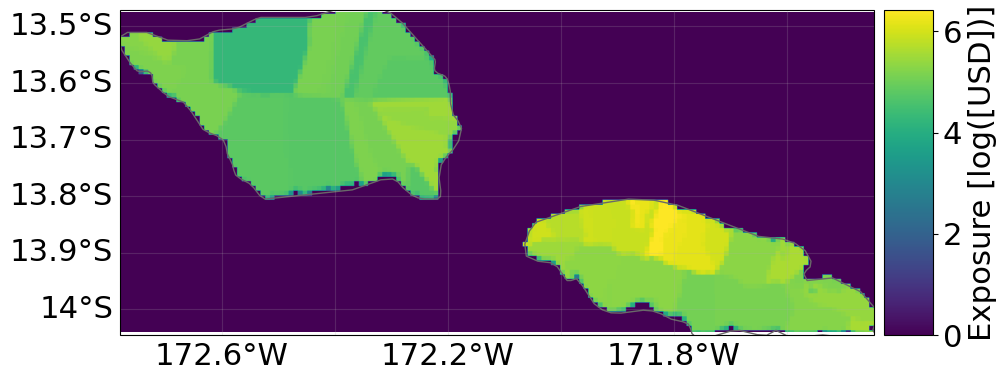

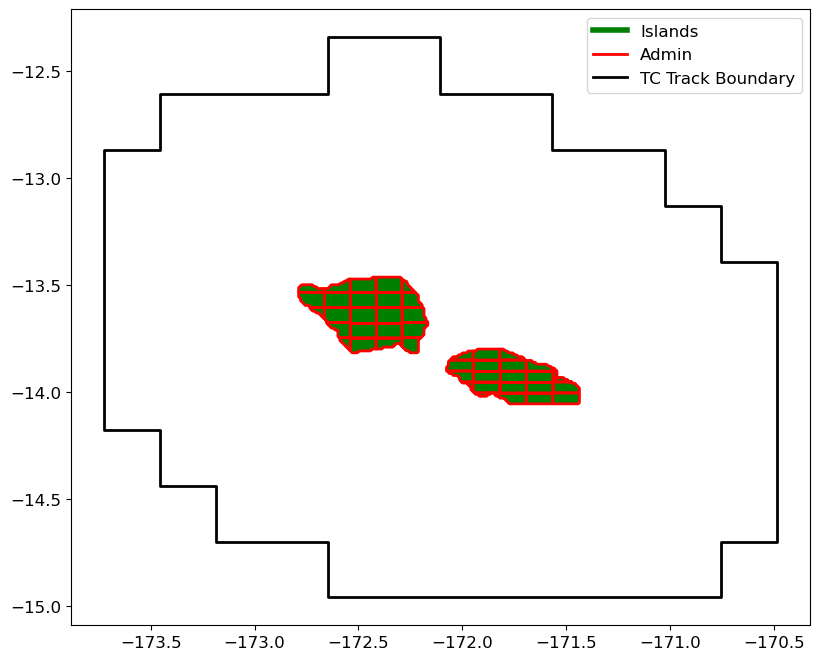

Number of tracks in SP basin: 3002


In [195]:
exp, applicable_basins, grid_gdf, admin_gdf, storm_basin_sub, tc_storms = exa.init_TC_exp(country, grid_specs=[5,5], buffer_distance_km=105, res_exp=30, buffer_grid_size=1, load_fls=True)
imp, imp_per_event, imp_admin_evt = cimp.init_imp(exp, tc_storms, admin_gdf, plot_frequ=False) 
imp_per_event_flt, imp_admin_evt_flt, to_protect = bpd.init_imp_flt(imp_per_event, imp_admin_evt, prot_share=lower_share, exposure=exp)
int_grid = hig.init_haz_int(grid_gdf, admin_gdf, tc_storms=tc_storms, stat=60) 
nominal = snom.init_nominal(impact=imp, exposure=exp, prot_rp=upper_rp, print_nom=False)
result, optimized_step1, optimized_step2 = apo.init_alt_optimization(int_grid, nominal, damages_grid=imp_admin_evt_flt, damages_evt=imp_per_event_flt, print_params=False)
pay_dam_df = apo.alt_pay_vs_damage(imp_per_event_flt, optimized_step1, optimized_step2, int_grid, nominal, imp_admin_evt)

## Select Historic Event

In [196]:
tr_test = TCTracks.from_ibtracs_netcdf(storm_id=['1991338S08181','1993029S11178'], basin='SP')
tr_test.equal_timestep(time_step_h=1)
tr_val= TCTracks.from_ibtracs_netcdf(storm_id=['1991338S08181'], basin='SP')
tr_lin= TCTracks.from_ibtracs_netcdf(storm_id=['1993029S11178'], file_name='IBTrACS.ALL.v04r01.nc')

2025-01-02 08:31:45,693 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\kaibe\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


c:\users\kaibe\climada\climada_python\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:
<string>:6: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
<string>:6: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.


2025-01-02 08:31:51,324 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\kaibe\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


c:\users\kaibe\climada\climada_python\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:
c:\users\kaibe\climada\climada_python\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


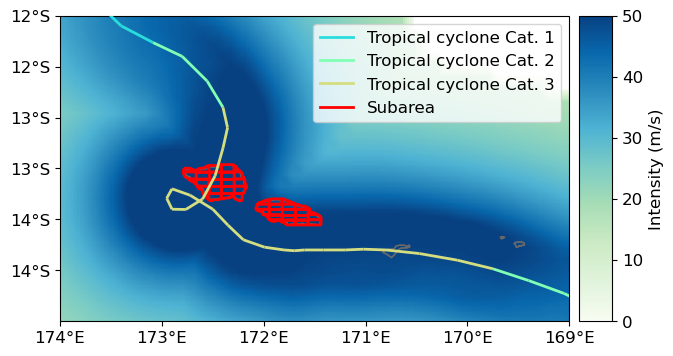

In [197]:
CAT_NAMES_VAL = {
    1: 'Tropical cyclone Cat. 1',
    2: 'Tropical cyclone Cat. 2',
    3: 'Tropical cyclone Cat. 3',
}
CAT_COLORS = cm_mp.rainbow(np.linspace(0, 1, 7))
leg_lines = [Line2D([0], [0], color=CAT_COLORS[i_col], lw=2) for i_col in range(2,5)]
leg_names = [CAT_NAMES_VAL[i_col] for i_col in sorted(CAT_NAMES_VAL.keys())]

leg_lines_admin = [Line2D([0], [0], color='red', lw=2)]
leg_names_admin = ['Subarea']
cmap0 = LinearSegmentedColormap.from_list('', ['white', *plt.cm.GnBu(np.arange(255))])
min_lat, max_lat, min_lon, max_lon = -15, -12, -174, -169
centrs = Centroids.from_pnt_bounds((min_lon, min_lat, max_lon, max_lat), res=0.12)
tc_test = TropCyclone.from_tracks(tr_test, centroids=centrs)
imp_test, imp_per_event_test, imp_admin_evt_test = cimp.init_imp(exp, tc_test, admin_gdf, plot_frequ=False)
projection= ccrs.PlateCarree()
plt.rcParams['font.size'] = '12'
fig, ax1 = plt.subplots(subplot_kw={"projection": projection})  # Use a Cartopy projection
ax1 = tc_test.plot_intensity('1991338S08181', cmap=cmap0, axis=ax1, smooth=True, vmin=0, vmax=50, zorder=1)
ax1.add_geometries(admin_gdf.geometry, crs=projection, edgecolor='red', linewidth=2, facecolor='none', zorder=2, label='Subareas')
tr_val.plot(axis=ax1, zorder=3, legend=False)
ax1.set_title('')
ax1.set_extent((-174, -169, -15, -12))
ax1.set_yticks(ax1.get_yticks()[1:])
ax1.set_xticks(ax1.get_xticks())
xlabel= ax1.get_xticks()
new_xlabel = []
for label in xlabel:
   new_xlabel.append(str(int(-label))+'°W') 
ax1.set_xticklabels(new_xlabel)

ylabel= ax1.get_yticks()
new_ylabel = []
for label in ylabel:
   new_ylabel.append(str(int(-label))+'°S') 
ax1.set_yticklabels(new_ylabel)
ax1.legend(leg_lines + leg_lines_admin, leg_names + leg_names_admin, loc=0)
plt.show()

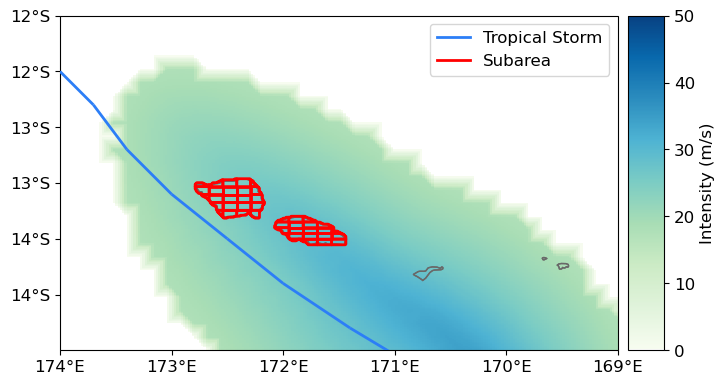

In [198]:
CAT_NAMES_LIN = {
    0: 'Tropical Storm',
}
CAT_COLORS = cm_mp.rainbow(np.linspace(0, 1, 7))
leg_lines = [Line2D([0], [0], color=CAT_COLORS[1], lw=2)]
leg_names = [CAT_NAMES_LIN[0]]
leg_lines_admin = [Line2D([0], [0], color='red', lw=2)]
leg_names_admin = ['Subarea']
cmap0 = LinearSegmentedColormap.from_list('', ['white', *plt.cm.GnBu(np.arange(255))])
min_lat, max_lat, min_lon, max_lon = -15, -12, -174, -169
centrs = Centroids.from_pnt_bounds((min_lon, min_lat, max_lon, max_lat), res=0.12)
tc_test = TropCyclone.from_tracks(tr_test, centroids=centrs)
imp_test, imp_per_event_test, imp_admin_evt_test = cimp.init_imp(exp, tc_test, admin_gdf, plot_frequ=False)
projection= ccrs.PlateCarree()
plt.rcParams['font.size'] = '12'
fig, ax1 = plt.subplots(subplot_kw={"projection": projection})  # Use a Cartopy projection
ax1 = tc_test.plot_intensity('1993029S11178', cmap=cmap0, axis=ax1, smooth=True, vmin=0, vmax=50, zorder=1)
ax1.add_geometries(admin_gdf.geometry, crs=projection, edgecolor='red', linewidth=2, facecolor='none', zorder=2)
tr_lin.plot(axis=ax1, zorder=3)
ax1.set_title('')
ax1.set_extent((-174, -169, -15, -12))
ax1.set_yticks(ax1.get_yticks()[1:])
ax1.set_xticks(ax1.get_xticks())
xlabel= ax1.get_xticks()
new_xlabel = []
for label in xlabel:
   new_xlabel.append(str(int(-label))+'°W') 
ax1.set_xticklabels(new_xlabel)

ylabel= ax1.get_yticks()
new_ylabel = []
for label in ylabel:
   new_ylabel.append(str(int(-label))+'°S') 
ax1.set_yticklabels(new_ylabel)
ax1.legend(leg_lines + leg_lines_admin, leg_names + leg_names_admin, loc=0)

## Show Test Results

In [199]:
from pathlib import Path

file_path = Path("C:/Users/kaibe/Documents/ETH_Zurich/Thesis/Data/hazard")
tc_storms_hist = TropCyclone.from_hdf5(file_path.joinpath("IBTRACS_SP_1980_2022_hist.hdf5"))
tc_storms_synth = TropCyclone.from_hdf5(file_path.joinpath("IBTRACS_SP_1980_2022.hdf5"))

tc_track_hist = TCTracks.from_hdf5(file_path.joinpath('TC_tracks_IBTRACS_SP_1980_2022_hist.hdf5'))
tc_track_synth = TCTracks.from_hdf5(file_path.joinpath('TC_tracks_IBTRACS_SP_1980_2022_synth.hdf5'))

In [200]:
tc_tracks_lines_hist = exa.to_geodataframe(tc_track_hist)
intersected_tracks_hist = gpd.sjoin(tc_tracks_lines_hist, grid_gdf, how='inner', predicate='intersects')
select_tracks_test_hist = tc_tracks_lines_hist.index.isin(intersected_tracks_hist.index)
tracks_in_exp_hist = [track for j, track in enumerate(tc_track_hist.data) if select_tracks_test_hist[j]]
tracks_in_exp_hist = TCTracks(tracks_in_exp_hist)

tc_tracks_lines_synth = exa.to_geodataframe(tc_track_synth)
intersected_tracks_synth = gpd.sjoin(tc_tracks_lines_synth, grid_gdf, how='inner', predicate='intersects')
select_tracks_test_synth = tc_tracks_lines_synth.index.isin(intersected_tracks_synth.index)
tracks_in_exp_synth = [track for j, track in enumerate(tc_track_synth.data) if select_tracks_test_synth[j]]
tracks_in_exp_synth = TCTracks(tracks_in_exp_synth)

c:\Users\kaibe\miniforge3\envs\climada_env\lib\site-packages\geopandas\geodataframe.py:204: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  object.__setattr__(self, attr, val)
c:\Users\kaibe\miniforge3\envs\climada_env\lib\site-packages\geopandas\geodataframe.py:204: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or

In [202]:
dam_pay_data_ibtracs_hist, rSquared_ibtracs_hist = fct.prod_test_ibtrac(tc_storms_hist, exp, admin_gdf, nominal, optimized_step1, 
                                                                        optimized_step2, imp_per_event_flt,
                                                                        imp_admin_evt_flt, lower_share)

dam_pay_data_ibtracs_synth, rSquared_ibtracs_synth = fct.prod_test_ibtrac(tc_storms_synth, exp, admin_gdf, nominal, optimized_step1, 
                                                                          optimized_step2, imp_per_event_flt,
                                                                          imp_admin_evt_flt, lower_share)

c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\functions.py:419: RuntimeWarning: divide by zero encountered in scalar divide
  rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)


RMSE: -inf
RMSE: 0.8390294758576958


In [203]:
names_hist = []
for i in range(len(tracks_in_exp_hist.data)):
    names_hist.append(tracks_in_exp_hist.data[i].sid)

names_synth = []
for i in range(len(tracks_in_exp_synth.data)):
    names_synth.append(tracks_in_exp_synth.data[i].sid)

dam_pay_data_ibtracs_hist['tc_boundary'] = dam_pay_data_ibtracs_hist['STORM_ID'].astype(str).isin(names_hist)
dam_pay_data_ibtracs_synth['tc_boundary'] = dam_pay_data_ibtracs_synth['STORM_ID'].astype(str).isin(names_synth)
dam_pay_data_ibtracs_hist['basis_risk'] = dam_pay_data_ibtracs_hist['pay'] / dam_pay_data_ibtracs_hist['imp']
dam_pay_data_ibtracs_synth['basis_risk'] = dam_pay_data_ibtracs_synth['pay'] / dam_pay_data_ibtracs_synth['imp']


True for STORM_ID: 1991338S08181
True for STORM_ID: 1990028S10183_gen6
True for STORM_ID: 1991338S08181
True for STORM_ID: 1991338S08181_gen4
True for STORM_ID: 1991338S08181_gen5
True for STORM_ID: 1991338S08181_gen6
True for STORM_ID: 1991338S08181_gen8
True for STORM_ID: 1991338S08181_gen9
True for STORM_ID: 2003359S15177_gen7
True for STORM_ID: 2005041S13181_gen1


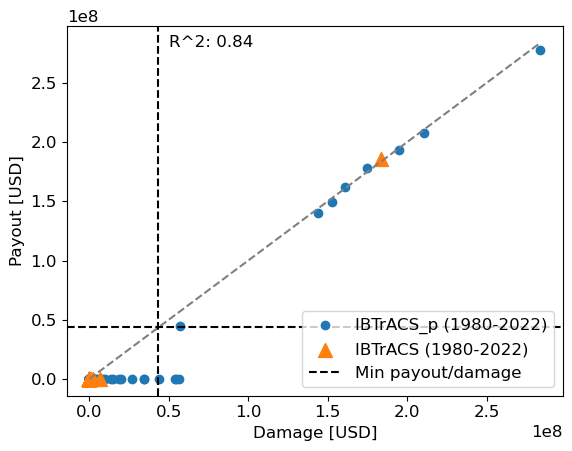

In [204]:
min_pay = lower_share * exp.gdf['value'].sum()
dam_pay_data_ibtracs_synth_flt = dam_pay_data_ibtracs_synth[dam_pay_data_ibtracs_synth['STORM_ID'].str.contains('_gen', na=False)]
plt.scatter(dam_pay_data_ibtracs_synth_flt['imp'], dam_pay_data_ibtracs_synth_flt['pay'], label='IBTrACS_p (1980-2022)')
plt.scatter(dam_pay_data_ibtracs_hist['imp'], dam_pay_data_ibtracs_hist['pay'], marker='^', s=100, label='IBTrACS (1980-2022)')
plt.plot([0, max(dam_pay_data_ibtracs_synth['imp'])], [0, max(dam_pay_data_ibtracs_synth['imp'])], color='gray', linestyle='--')
plt.axvline(x=min_pay, color='black', linestyle='--', label='Min payout/damage')
plt.axhline(y=min_pay, color='black', linestyle='--')
plt.text(0.5e8, 2.8e8, f'R^2: {round(rSquared_ibtracs_synth, 2)}', fontsize=12)
plt.xlabel('Damage [USD]', fontsize=12)
plt.ylabel('Payout [USD]', fontsize=12)
plt.legend()
plt.show()

In [211]:
print(f"Mean: {dam_pay_data_ibtracs_synth[dam_pay_data_ibtracs_synth['pay'] > min_pay]['basis_risk'].mean()}")
print(f"Max: {dam_pay_data_ibtracs_synth[dam_pay_data_ibtracs_synth['pay'] > min_pay]['basis_risk'].min()}")
print(f"Min: {dam_pay_data_ibtracs_synth[dam_pay_data_ibtracs_synth['pay'] > min_pay]['basis_risk'].max()}")

Mean: 0.9704241334960719
Max: 0.784446728328933
Min: 1.0204587018156097


In [213]:
dam_pay_data_ibtracs_synth[dam_pay_data_ibtracs_synth['imp'] >= min_pay]['pay'].sum() / dam_pay_data_ibtracs_synth[dam_pay_data_ibtracs_synth['imp'] >= min_pay]['imp'].sum()

0.8689953427162137